# **TEST DELL'IMPLEMENTAZIONE DELLE CELLE DI VERLET**

In [1]:
list_N_atoms = [108, 256, 500, 864, 1372, 2048]
def build_nomefile(N_atoms):
    return f"../../../data/pos-fcc100-minime/C_s=5e-4~F_t=5e-4~max_s=50k/fcc100a{N_atoms}_1.txt"

### Importazioni

In [2]:
from CMS.MolecularDynamics.CrystalStructure import CrystalStructure as Crystal
from CMS.MolecularDynamics.CrystalDynamics import CrystalDynamics

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import time

### Dati

In [3]:
# temperature da studiare
temperatura = [50, 300, 850] # in K, cerco una temperatura finale ~850 K (rescale velocità)

# massa atomica dell'atomo considerato (argento)
silver_mass = 108

# time step ottimale per ciascuna temperatura
time_step = {
    50: 20e-15, # 5000 step -> 100 ps
    300: 6e-15, # 5000 step -> 30 ps
    850: 4e-15  # 5000 step -> 20 ps
}

# scelgo di simulare per un numero di step fisso
n_steps = 5000

# tempo di termalizzazione (ogni valore precedente va buttato)
t_th = 3e-12

# per vedere la differenza nel tempo di simulazione: con e senza verlet cage
R_V_test = [4.6, 5.0, 5.4, np.inf]  # in Angstrom

result = {}
simulation_time = {}

### Simulazione

**6 valori di R_V, 6 valori di N: 36 simulazioni diverse**
- Struttura a matrici booleane: 15min
- Struttura a neighbours_list: 6 min [meno della metà!!!]

**3 temperature, 4 valori di R_V, 6 valori di N: 72 simulazioni diverse**
- Struttura a neighbours_list: ? min

In [4]:
for T in temperatura:
    print(f"🚀 Avvio simulazione con T={T} K")
    result[T] = {}
    simulation_time[T] = {}
    for R_V in R_V_test:
        print(f"• R_V={R_V} Angstrom")
        result[T][R_V] = {}
        simulation_time[T][R_V] = {}
        print(f"N =", end=" ")
        for N in list_N_atoms:
            print(f"{N},", end=" ")
            start_time = time.time()
            # Inizializzo il cristallo dal file minimizzato con steepest-descent
            filename = build_nomefile(N)
            cristallo = Crystal.from_file(filename)
            # Setto il raggio di cutoff E la giunzione polinomiale
            cristallo.set_R_C(4.5)
            cristallo.set_R_P(4.2)
            cristallo.set_R_V(R_V)
            # condizioni al contorno periodiche (vanno settate DOPO R_C)
            # cristallo.set_pbc(pbc)

            # Raccolgo le energie medie e le dev std
            simulazione = CrystalDynamics(
                cristallo, 
                atomic_mass=silver_mass, 
                dt=time_step[T], 
                temp_ini=T, 
                atom_tracker=None, 
                xyz_writer=None
            )  
            simulazione.set_seed(12316543)

            # stavolta output True per visualizzare con ovito
            result[T][R_V][N] = simulazione.run_dynamics(
                n_steps=n_steps, 
                t_th=t_th,
                rescale_velocity=True,
                debug=False
            )
            
            end_time = time.time()
            simulation_time[T][R_V][N] = end_time - start_time
        print("\n")

🚀 Avvio simulazione con T=50 K
• R_V=4.6 Angstrom
 - N=108 atomi
 - N=256 atomi
 - N=500 atomi
 - N=864 atomi
 - N=1372 atomi
 - N=2048 atomi
• R_V=5.0 Angstrom
 - N=108 atomi
 - N=256 atomi
 - N=500 atomi
 - N=864 atomi
 - N=1372 atomi
 - N=2048 atomi
• R_V=5.4 Angstrom
 - N=108 atomi
 - N=256 atomi
 - N=500 atomi
 - N=864 atomi
 - N=1372 atomi
 - N=2048 atomi
• R_V=inf Angstrom
 - N=108 atomi
 - N=256 atomi
 - N=500 atomi
 - N=864 atomi
 - N=1372 atomi
 - N=2048 atomi
🚀 Avvio simulazione con T=300 K
• R_V=4.6 Angstrom
 - N=108 atomi
 - N=256 atomi
 - N=500 atomi
 - N=864 atomi
 - N=1372 atomi
 - N=2048 atomi
• R_V=5.0 Angstrom
 - N=108 atomi
 - N=256 atomi
 - N=500 atomi
 - N=864 atomi
 - N=1372 atomi
 - N=2048 atomi
• R_V=5.4 Angstrom
 - N=108 atomi
 - N=256 atomi
 - N=500 atomi
 - N=864 atomi
 - N=1372 atomi
 - N=2048 atomi
• R_V=inf Angstrom
 - N=108 atomi
 - N=256 atomi
 - N=500 atomi
 - N=864 atomi
 - N=1372 atomi
 - N=2048 atomi
🚀 Avvio simulazione con T=850 K
• R_V=4.6 Angstro

---

## **Analisi**

## Plot $\delta E / \langle E \rangle$ v $N$

Dal grafico $\delta E / \langle E \rangle$ v $N$ mi aspetto di vedere un comportamento come 1/√N. La verlet cage non dovrebbe influire: lo uso come confronto a garanzia che i risultati restino invariati. È brutto da vedere ma funziona: si distinguono solo tre curve, una per ogni temperatura. Ogni curva in realtà sono 4 curve sovrapposte: una per ogni valore di $R_V$. È confermato che $R_V$ NON modifica il risultato.

In [5]:
def radice (N, A):
    return A / np.sqrt(N)

In [6]:
rapporti_dict = {}
for T in temperatura:
    rapporti = {R_V: [result[T][R_V][N].std_E_tot / abs(result[T][R_V][N].mean_E_tot) for N in list_N_atoms] for R_V in R_V_test}
    rapporti_dict[T] = rapporti

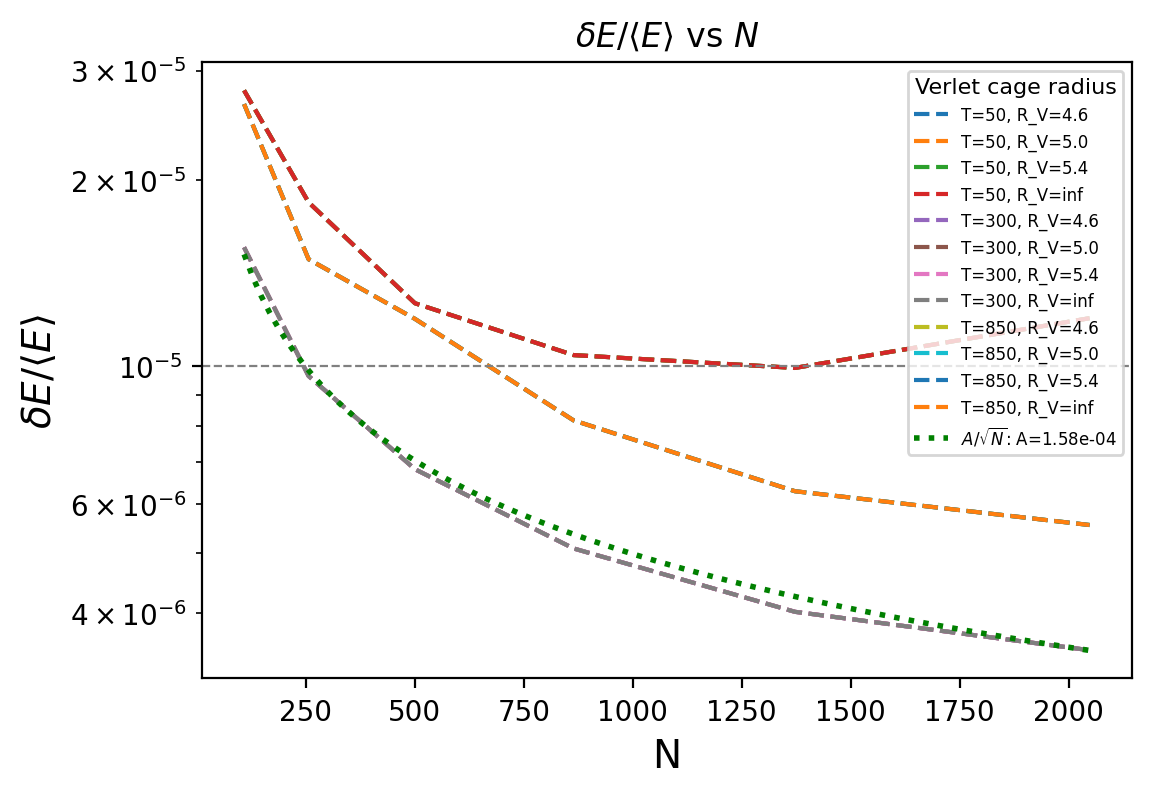

In [7]:
plt.figure(figsize=(6,4), dpi=200)

# plotto #
for T in temperatura:
    for R_V in R_V_test:
        plt.plot(list_N_atoms, rapporti_dict[T][R_V], 
                linestyle='--', linewidth=1.5, label=f'T={T}, R_V={R_V}')

# fitto con 1/√N #
p0 = [-4.74E-5]  # valori iniziali per A
low = [-np.inf]  # limiti inferiori per A
upp = [np.inf]  # limiti superiori per A
popt, _ = curve_fit(radice, list_N_atoms, rapporti_dict[300][R_V_test[0]], p0=p0, bounds=(low, upp))
x_fit = np.linspace(min(list_N_atoms), max(list_N_atoms), 100)
y_fit = radice(x_fit, *popt)
plt.plot(x_fit, y_fit, color='green', linestyle=':', linewidth=2, label=f'$A/\\sqrt{{N}}$: A={popt[0]:.2e}')

# opzioni #
plt.axhline(1E-05, color='grey', linewidth=0.8, linestyle='--')
plt.xlabel('N', fontsize=14)
plt.ylabel(r'$\delta E/\langle E \rangle$', fontsize=14)
plt.yscale('log')
leg = plt.legend(title='Verlet cage radius', fontsize=6, title_fontsize=8)
#leg.get_title().set_fontweight('bold')
plt.title(r"$\delta E/\langle E \rangle$ vs $N$")
plt.show()

---

## Tempo CPU v $N$ al variare di $R_V$

La speranza è quella di vedere il comportamento per $N$ grandi passare da $\mathbb{O}(N^2)$ a $\mathbb{O}(N)$. Il tempo CPU diminuisce moltissimo, il comportamento però sembra ancora quadratico. Ricordiamo che, ogni tot steps, si ha un evento di 'crossing' della cella di Verlet: se un atomo si sposta viene richiesto il ricomputo integrale dei vicini. Questa rimane un'operazione $\mathbb{O}(N^2)$; per quanto il $R_V$ possa ridurre il numero delle volte in cui succede, continuerà a succedere. Un possibile ulteriore miglioramento è l'implementazione delle _linked cells_: dividere la struttura cristallina in più celle e darle in pasto a processori differenti, considerando in ciascun processo soltanto le 26 celle contigue (un cubo di lato 9 senza considerare quella centrale).

<img src="images/linked-cells.png" 
     style="display: block; margin-left: auto; margin-right: auto; margin-top: 5px; width: 300px;">

In [8]:
# Funzioni di fit
def quadratica (N, A):
    return A * N*N

def lineare (N, A):
    return A * N

<>:47: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\c'
/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_68605/1045547165.py:47: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(x_fit, y_fit_lin, color='black', linestyle=':', linewidth=1, label=f'$A\cdot N$')


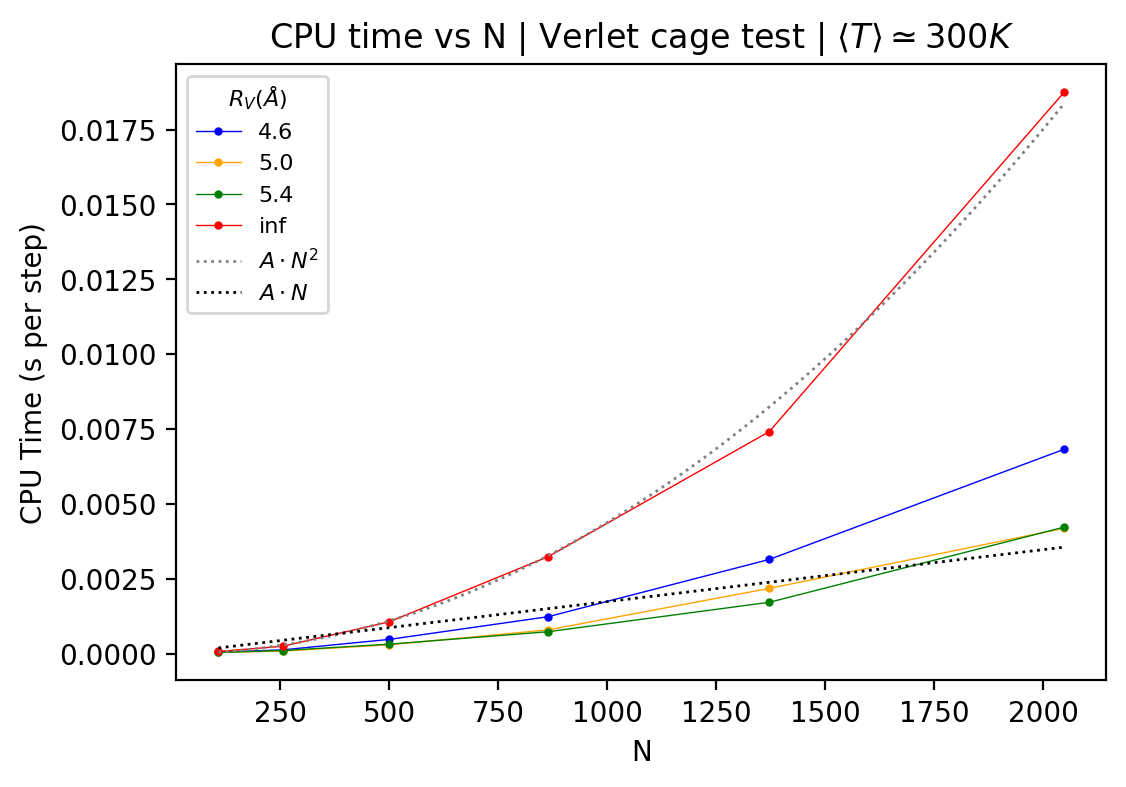

In [10]:
plt.figure(figsize=(6,4), dpi=200)

linestyle = {
    50: 'dashdot',
    300: 'solid',
    850: 'dashed',
}

color = {
    4.6: 'blue',
    5.0: 'orange',
    5.4: 'green',
    np.inf: 'red'
}

marker = {
    50: 's',
    300: 'o',
    850: '^',
}


# plotto #
labelized = False
# era predisposto per plottare tutte le temperature, ma ora solo T=300 K
for T in [temperatura[1]]:
    for R_V in R_V_test:
        list_times = [simulation_time[T][R_V][N]/n_steps for N in list_N_atoms]
        plt.plot(
            list_N_atoms,
            list_times,
            label=f'{R_V}' if not labelized else "",
            linestyle=linestyle[T], color=color[R_V], linewidth=0.5, marker=marker[T], markersize=2)
    labelized = True
    
# FIT #
without_verlet = [simulation_time[300][np.inf][N]/n_steps for N in list_N_atoms]
with_verlet = [simulation_time[300][5][N]/n_steps for N in list_N_atoms]
# fit quadratico della curva senza verlet cage
popt_quad, _ = curve_fit(quadratica, list_N_atoms, without_verlet)
# fit lineare della curva con verlet cage a R_V=5
popt_lin, _ = curve_fit(lineare, list_N_atoms, with_verlet, p0=[0.001])
x_fit = np.linspace(min(list_N_atoms), max(list_N_atoms), 100)
y_fit_quad = quadratica(x_fit, *popt_quad)
y_fit_lin = lineare(x_fit, *popt_lin)
plt.plot(x_fit, y_fit_quad, color='gray', linestyle=':', linewidth=1, label=f'$A\\cdot N^2$')
plt.plot(x_fit, y_fit_lin, color='black', linestyle=':', linewidth=1, label=f'$A\cdot N$')
    
# opzioni #
plt.xlabel('N')
plt.ylabel('CPU Time (s per step)')
leg = plt.legend(title='$R_V (\\AA)$', fontsize=8, title_fontsize=8)
#leg.get_title().set_fontweight('bold')
plt.title(r"CPU time vs N | Verlet cage test | $\langle T \rangle \simeq 300 K$")
plt.show()